In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ncistd import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
# custom continuous cmap 
grad_hexes = ['#9B5DE5', '#FFAC69']
grad_cmap = get_continuous_cmap(grad_hexes)

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# Collect data

In [4]:
# look at data

data_dir = Path('../../data/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,model_fms,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,NaN,0.968409,NaN,0.976258,NaN,0.863145,0.745020,0.733815,0.996628,0.270695
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,0.998166,NaN,0.998288,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,0.998503,NaN,0.998615,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,NaN,0.969926,NaN,0.977179,NaN,0.863145,0.745020,0.733815,0.996628,0.270695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,B,...,NaN,0.037424,NaN,0.077594,NaN,0.050306,0.001616,0.003607,1.000000,0.000002
107996,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,C,...,0.026481,NaN,0.102243,NaN,0.131446,NaN,NaN,NaN,NaN,NaN
107997,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107998,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separate out a dataframe of summary simulation information

# pull out simulation information
simulation_info_df = results_df[
    [
        'simulation_id', 
        'simulation_rank', 
        'simulation_shape', 
        'simulation_densities', 
        'simulation_mean_gene_sparsity', 
        'noise_level'
    ]
].drop_duplicates().reset_index(drop=True)
# separate out shape densities
simulation_info_df['mode0_length'] = [int(i[0]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode1_length'] = [int(i[1]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode2_length'] = [int(i[2]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
# separate out factor densities
simulation_info_df['factor0_density'] = [float(i[0]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor1_density'] = [float(i[1]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor2_density'] = [float(i[2]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df.drop(columns='simulation_densities', inplace=True)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218


In [6]:
# separate out ground truth data 
# compares models against simulation ground truth

gt_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
gt_df = gt_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'true_fms', 'true_factor0_cosine_similarity', 'true_factor0_support_cosine_similarity', 
    'recovery', 'relevance', 'precision', 'recall'
]].reset_index(drop=True)
# derived metrics
gt_df['recovery_relevance'] = (gt_df['recovery'] + gt_df['relevance']) / 2
gt_df['precision_recall'] = (gt_df['precision'] + gt_df['recall']) / 2

# generate separate dataframe for aggregated metrics
gt_df_agg = gt_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    gt_sse_mean=('relative_sse', 'mean'), 
    gt_fms_mean=('true_fms', 'mean'), 
    gt_cossim_f0_mean=('true_factor0_cosine_similarity', 'mean'), 
    gt_sup_cossim_f0_mean=('true_factor0_support_cosine_similarity', 'mean'), 
    gt_recovery_mean=('recovery', 'mean'), 
    gt_relevance_mean=('relevance', 'mean'), 
    gt_precision_mean=('precision', 'mean'), 
    gt_recall_mean=('recall', 'mean'), 
    gt_recovery_relevance_mean=('recovery_relevance', 'mean'), 
    gt_precision_recall_mean=('precision_recall', 'mean')
).reset_index()

gt_df_agg


,simulation_id,rank,lambda,gt_sse_mean,gt_fms_mean,gt_cossim_f0_mean,gt_sup_cossim_f0_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_recovery_relevance_mean,gt_precision_recall_mean
0,0,1,0.00,0.735901,0.969171,0.976720,0.863145,0.745020,0.733815,0.996628,0.270695,0.739417,0.633662
1,0,1,0.05,0.735984,0.970011,0.977314,0.867079,0.755146,0.720852,0.997566,0.238764,0.737999,0.618165
2,0,1,0.10,0.736225,0.970759,0.977813,0.870215,0.762470,0.709512,0.998171,0.218749,0.735991,0.608460
3,0,1,0.20,0.737150,0.971796,0.978398,0.876991,0.776318,0.688529,0.998335,0.192815,0.732424,0.595575
4,0,1,0.40,0.740531,0.972065,0.977972,0.879279,0.784032,0.645270,0.998758,0.150848,0.714651,0.574803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,99,12,0.80,0.956627,0.708852,0.752750,0.857113,0.683542,0.750353,0.381388,0.998530,0.716947,0.689959
11996,99,12,1.60,0.961775,0.598320,0.668967,0.784456,0.563823,0.629176,0.737336,0.898814,0.596499,0.818075
11997,99,12,3.20,0.971610,0.476196,0.550377,0.606728,0.325723,0.371192,0.983404,0.333843,0.348457,0.658623
11998,99,12,6.40,0.985889,0.247152,0.312619,0.347487,0.102244,0.159379,0.999264,0.034346,0.130812,0.516805


In [7]:
# separate out cross validation data
# compares each model fit to one replicate against models fit to the other two replicates

cv_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
cv_df = cv_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'comparison_replicate', 
    'replicate_pair', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'model_fms', 'model_factor0_cosine_similarity', 'model_factor0_support_cosine_similarity'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
cv_df_agg = cv_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    cv_sse_mean=('relative_sse', 'mean'), 
    cv_sse_sem=('relative_sse', 'sem'), 
    cv_fms_mean=('model_fms', 'mean'), 
    cv_fms_sem=('model_fms', 'sem'), 
    cv_f0_cossim_mean=('model_factor0_support_cosine_similarity', 'mean'), 
    cv_f0_cossim_sem=('model_factor0_support_cosine_similarity', 'sem')
).reset_index()

cv_df_agg


,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem,cv_f0_cossim_mean,cv_f0_cossim_sem
0,0,1,0.00,0.736795,0.000476,0.998302,0.000103,1.000000,0.000000
1,0,1,0.05,0.736867,0.000466,0.998290,0.000106,0.978432,0.002164
2,0,1,0.10,0.737093,0.000457,0.998283,0.000105,0.974796,0.000410
3,0,1,0.20,0.737988,0.000437,0.998250,0.000105,0.970320,0.002383
4,0,1,0.40,0.741327,0.000401,0.998122,0.000111,0.983923,0.001078
...,...,...,...,...,...,...,...,...,...
11995,99,12,0.80,0.999966,0.000286,0.191279,0.005289,0.768043,0.003625
11996,99,12,1.60,0.994789,0.000239,0.174680,0.005152,0.591805,0.000954
11997,99,12,3.20,0.991354,0.000129,0.169882,0.005800,0.373454,0.004125
11998,99,12,6.40,0.994599,0.000080,0.111894,0.002197,0.188107,0.001287


# Define optimal rank

The rank of the model with the minimum SSE value, excluding all models fit without a sparsity penalty (lambda=0)

In [8]:
# find the optimal rank parameter for each simulation based on minimum sse

# drop the lambda=0 data, since this does not always show a minimum
# rank_optima_df = cv_df[cv_df['lambda'] != 0]
rank_optima_df = cv_df.copy()
# select the sse minimum for each simulation
rank_optima_df = rank_optima_df.loc[rank_optima_df.groupby('simulation_id').relative_sse.idxmin(), :]
# map optimal rank back to simulation_info_df
rank_optima = rank_optima_df.set_index('simulation_id')['rank']
simulation_info_df['optimal_rank'] = simulation_info_df['simulation_id'].map(rank_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,optimal_rank
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,8
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,8
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,3
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,4
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,9
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,1
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,7
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,5


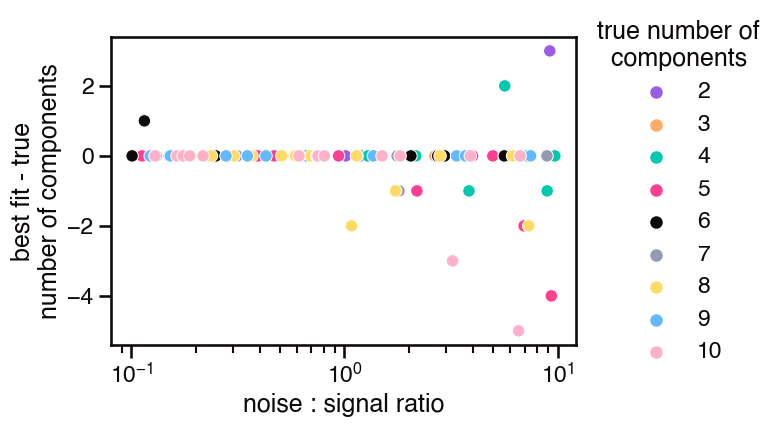

In [9]:
# plot true rank vs. optimal rank

# arrange data for plotting
rank_plot_df = simulation_info_df.copy()
rank_plot_df['min_cv_sse'] = rank_plot_df['simulation_id'].map(
    rank_optima_df.set_index('simulation_id')['relative_sse']
)
rank_plot_df['best fit rank - true rank'] = rank_plot_df['optimal_rank'] - rank_plot_df['simulation_rank']
rank_plot_df = rank_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
rank_plot_df['simulation_rank'] = rank_plot_df['simulation_rank'].astype(str)

# create plot
fig_1a, ax_1a = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='best fit rank - true rank', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_1a
)
plt.xlabel('noise : signal ratio');
plt.ylabel('best fit - true\nnumber of components');
plt.xscale('log')
plt.legend(title='true number of\n  components', loc='center left', bbox_to_anchor=[1, .5]);
# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


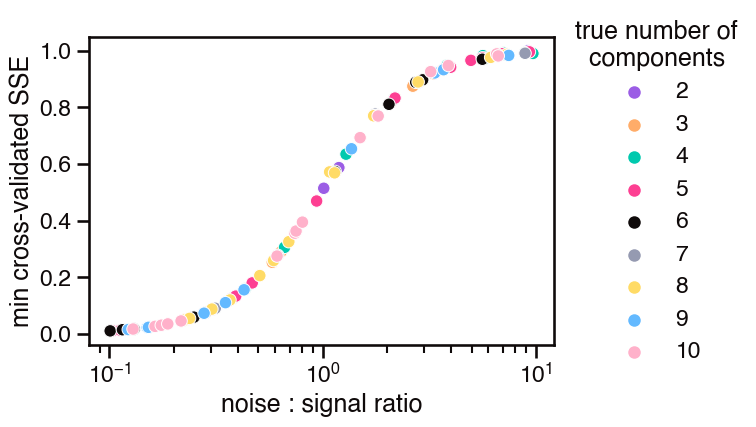

In [10]:
# plot relative sse of best cv replicate vs noise

# make plot
fig_s1, ax_s1 = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='min_cv_sse', 
    hue='simulation_rank', 
    data=rank_plot_df, 
    ax=ax_s1
);
plt.xlabel('noise : signal ratio');
plt.ylabel('min cross-validated SSE');
plt.xscale('log')
plt.legend(title='true number of\n  components', loc='center left', bbox_to_anchor=[1, .5]);
plt.savefig('best_sse_v_noise.png', bbox_inches='tight')


# Define optimal sparsity

Ground truth optimal sparsity is estimated by comparing cluster membership metrics between the fit models and the simulation ground truth.

Metrics to look at cluster membership of mode-0 factor matrix:
* Cosine similarity of mode-0 factor matrix support
* Precision-recall of mode-0 factor matrix support

These two metrics result in similar estimations of optimal sparsity. Max precision-recall is selected as the defining metric for ease of comprehension.


In [11]:
# find optimal lambda values based on cosine similarity (of values and support), precision-recall, and FMS

# make dataframe to store results
optimal_lambda_df = simulation_info_df.copy()
optimal_lambda_df['log noise:signal'] = np.log10(optimal_lambda_df['noise_level'])

# set up dataframe for selecting best lambda
lambda_df = gt_df_agg.copy()
lambda_df['optimal_rank'] = lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_df = lambda_df[lambda_df['rank'] == lambda_df['optimal_rank']].reset_index(drop=True)
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
lambda_df = lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)

# set up naming conventions (gt = ground truth)
# CSS = cosine similarity score, SCSS = support cosine similary score, MPRS = mean precision recall score
variables = [
    ('gt_fms_mean', 'fms'), 
    ('gt_cossim_f0_mean', 'css_f0'), 
    ('gt_precision_mean', 'precision'), 
    ('gt_recall_mean', 'recall'), 
    ('gt_precision_recall_mean', 'mprs'), 
    ('gt_sup_cossim_f0_mean', 'scss_f0')
]

# collect the max scores for each metric, along with the lambda values of the max
for (metric, var_name) in variables:
    # find max value of metric
    metric_df = lambda_df.loc[lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df['max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,max_css_f0,lambda_max_css_f0,max_precision,lambda_max_precision,max_recall,lambda_max_recall,max_mprs,lambda_max_mprs,max_scss_f0,lambda_max_scss_f0
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.989703,0.05,1.000000,6.4,1.000000,0.00,0.939164,0.10,0.954647,0.10
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,...,0.998758,0.05,1.000000,6.4,1.000000,0.00,0.934748,0.20,0.961857,0.20
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,...,0.921588,0.40,1.000000,6.4,1.000000,0.00,0.727147,1.60,0.824679,1.60
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,...,0.999892,0.20,1.000000,12.8,1.000000,0.05,0.976727,0.80,0.988070,0.80
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,...,0.941235,0.80,0.999947,12.8,1.000000,0.00,0.790488,3.20,0.857863,3.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,...,0.999932,0.00,1.000000,12.8,1.000000,0.00,0.997922,0.00,0.998959,0.00
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,...,0.820873,3.20,1.000000,12.8,0.863039,0.00,0.733772,0.05,0.686863,0.05
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,...,0.857207,0.05,0.999590,6.4,0.999955,0.00,0.818742,0.40,0.793131,0.40
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,...,0.999424,0.00,1.000000,6.4,1.000000,0.00,0.973621,0.10,0.984716,0.20


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


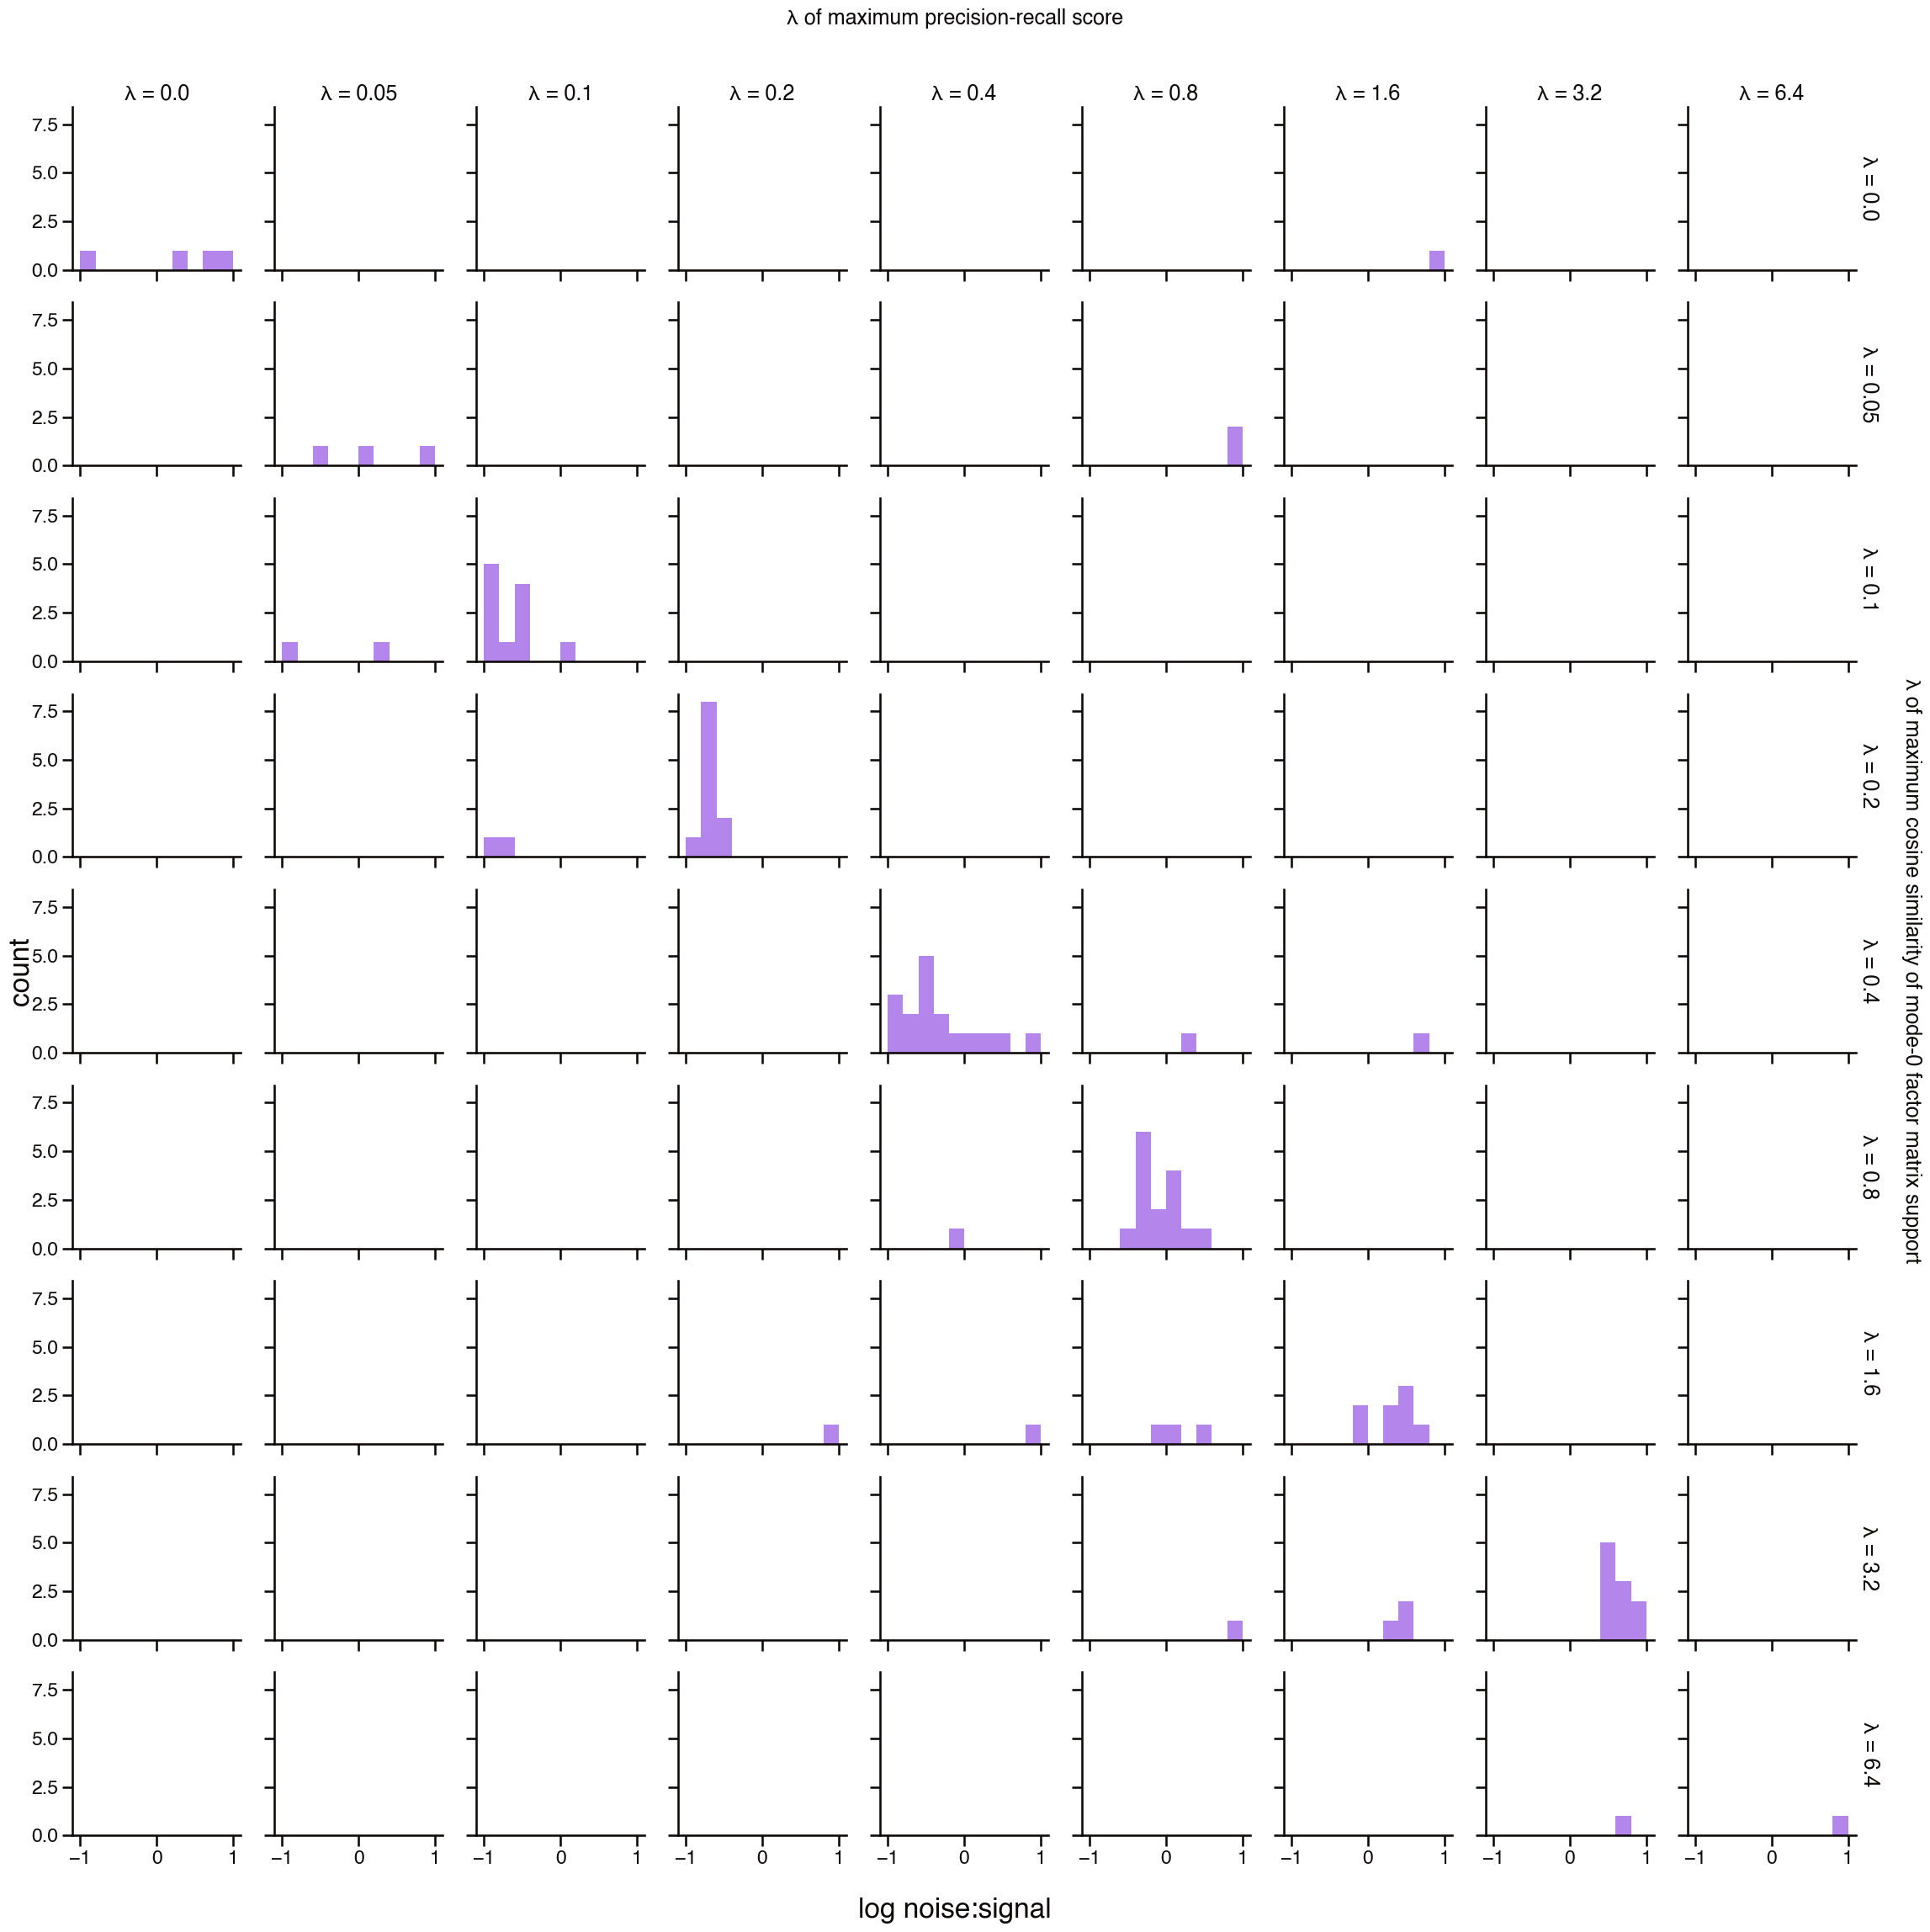

In [12]:
# plot a histogram grid comparing optimal lambdas according to precision recall & support cosine similarity

# parameterize FacetGrid
g = sns.FacetGrid(
    optimal_lambda_df, 
    row='lambda_max_scss_f0', 
    col='lambda_max_mprs', 
    margin_titles=True, 
    height=2.5
)

# plot data
g.map(sns.histplot, 'log noise:signal', color=sns.color_palette()[0], bins=10, binrange=(-1, 1));
# g.map(sns.histplot, 'factor0_density', color=sns.color_palette()[1], bins=10, binrange=(0, 1));
# g.map(sns.histplot, 'mode0_length', color=sns.color_palette()[2], bins=10, binrange=(0, 1000));

# adjust figure
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles(row_template='λ = {row_name}', col_template='λ = {col_name}');
# g.set_axis_labels('log noise:signal', 'count')
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='log noise:signal', fontdict={'fontsize':24});
g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
g.fig.text(.5, 1, ha='center', s='λ of maximum precision-recall score');
g.fig.text(1, .5, rotation=270, va='center', s='λ of maximum cosine similarity of mode-0 factor matrix support');


In [13]:
# set ground truth optimal sparsity as the sparsity of the maximum MPRS
optimal_lambda_df['optimal_lambda'] = optimal_lambda_df['lambda_max_mprs']

# map back to simulation_info_df
simulation_info_df['optimal_lambda'] = simulation_info_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['optimal_lambda']
)

# look at examples where optimal lambda (lambda of max MPRS) doesn't match lambda of max SCSS
optimal_lambda_df[optimal_lambda_df['optimal_lambda'] != optimal_lambda_df['lambda_max_scss_f0']]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_max_css_f0,max_precision,lambda_max_precision,max_recall,lambda_max_recall,max_mprs,lambda_max_mprs,max_scss_f0,lambda_max_scss_f0,optimal_lambda
7,7,6,"(256, 79, 75)",81.264655,5.619721,256,79,75,0.317440,0.762586,...,1.6,1.000000,12.8,1.000000,0.20,0.798156,3.20,0.871396,6.40,3.20
13,13,4,"(51, 43, 35)",5.093007,5.648308,51,43,35,0.099863,0.635820,...,0.4,1.000000,3.2,1.000000,0.00,0.663240,1.60,0.782116,0.40,1.60
14,14,7,"(892, 26, 92)",681.140631,8.912314,892,26,92,0.763611,0.773211,...,0.4,1.000000,12.8,1.000000,0.00,0.882733,1.60,0.873827,0.00,1.60
18,18,6,"(924, 84, 57)",650.312094,0.115104,924,84,57,0.703801,0.129460,...,0.0,1.000000,3.2,1.000000,0.00,0.874116,0.05,0.903424,0.10,0.05
32,32,4,"(59, 36, 46)",29.916030,7.057324,59,36,46,0.507051,0.189809,...,0.4,1.000000,6.4,0.972980,0.00,0.790892,0.40,0.887650,1.60,0.40
38,38,10,"(477, 35, 54)",383.186628,0.750807,477,35,54,0.803326,0.740958,...,0.1,1.000000,12.8,1.000000,0.00,0.943846,0.40,0.955525,0.80,0.40
40,40,5,"(579, 58, 18)",206.086053,6.957416,579,58,18,0.355934,0.222139,...,0.8,1.000000,6.4,0.999303,0.00,0.670434,0.20,0.829146,1.60,0.20
42,42,9,"(146, 60, 40)",60.077590,3.358210,146,60,40,0.411490,0.495025,...,0.8,1.000000,12.8,1.000000,0.20,0.824381,1.60,0.869344,3.20,1.60
46,46,5,"(670, 24, 82)",18.015705,2.186855,670,24,82,0.026889,0.952523,...,0.2,1.000000,3.2,1.000000,0.00,0.728225,0.80,0.905532,0.40,0.80
54,54,10,"(595, 55, 39)",359.575424,0.804616,595,55,39,0.604328,0.771644,...,0.2,1.000000,6.4,1.000000,0.05,0.922698,0.80,0.946405,1.60,0.80


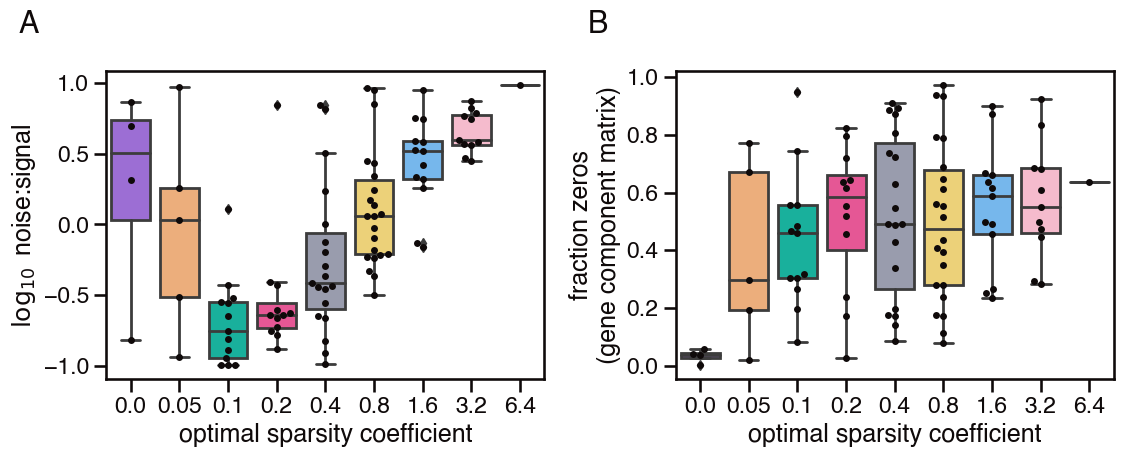

In [14]:
# plot optimal lambda by noise

# curate data
plot_df = optimal_lambda_df
plot_df['true sparsity'] = (1 - plot_df['factor0_density'])
plot_df = plot_df.sort_values('optimal_lambda')

# plot figure
fig, axis = plt.subplots(1, 2, figsize=[13, 4])
for i, var in enumerate(['log noise:signal', 'true sparsity']):
    sns.boxplot(
        x='optimal_lambda', 
        y=var, 
        data=plot_df, 
        ax=axis[i], 
        palette=[accent_colors[i] for i in [0, 1, 2, 3, 5, 6, 7, 8]]
    )
    sns.swarmplot(
        x='optimal_lambda', 
        y=var, 
        data=plot_df, 
        ax=axis[i], 
        color=accent_colors[4]
    )
    axis[i].annotate({0: 'A', 1: 'B'}[i], xy=(-0.2, 1.15), **annot_kwgs)
    axis[i].set_xlabel('optimal sparsity coefficient')
    axis[i].set_ylabel({
        'log noise:signal': '$\log_{10}$ noise:signal', 
        'true sparsity': 'fraction zeros\n(gene component matrix)'
    }[var])
    
plt.subplots_adjust(wspace=0.3)
plt.savefig('defining-optimal-lambda.png', bbox_inches='tight')


# Compare methods of picking optimal sparsity

Within the optimal rank, find lambda corresponding to:
* Minimum of cross-validated SSE
* Inflection point of cross-validated SSE (maximum change in slope)
* Maximum of cross-validated FMS
* Inflection point of cross-validated FMS (minimum change in slope)
* Maximum lambda within 1 standard error of minimum cross-validated SSE 
* Maximum lambda within 1 standard error of maximum cross-validated FMS 

Score as sum of absolute values of difference between log(selected lambda) and log(optimal lambda)


In [15]:
# find optima of different selection criteria based on cross-validated scoring metrics

# set up dataframe for selecting best lambda based on cross validation data
cv_lambda_df = cv_df_agg.copy()
cv_lambda_df['optimal_rank'] = cv_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
cv_lambda_df = cv_lambda_df[cv_lambda_df['rank'] == cv_lambda_df['optimal_rank']]

# drop lambda=0 values, under the assumption that at least some regularization will be imposed on the model
cv_lambda_df = cv_lambda_df[cv_lambda_df['lambda'] != 0].reset_index(drop=True)

# calculate inflection points for SSE and FMS
for simid in cv_lambda_df.simulation_id.unique():
    # find SSE inflection point
    sse_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_sse_mean']
    d2ydx_sse = np.pad(np.diff(np.diff(sse_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[sse_vector.index, 'd2ydx_sse'] = d2ydx_sse
    # find FMS inflection point
    fms_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_fms_mean']
    d2ydx_fms = np.pad(np.diff(np.diff(fms_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[fms_vector.index, 'd2ydx_fms'] = d2ydx_fms
    
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
cv_lambda_df = cv_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)  

# for each simulation, calculate max lambda corresponding to SSE <= to min(SSE) + SEM(min(SSE))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_sse_mean'].idxmin(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_sse_mean'] + metric_df['cv_sse_sem']))
cv_lambda_df['min_cv_sse_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where SSE <= to min(SSE) + SEM(min(SSE))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_sse_mean'].le(cv_lambda_df['min_cv_sse_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_min_cv_sse_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# for each simulation, calculate max lambda corresponding to FMS >= to max(FMS) - SEM(max(FMS))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_fms_mean'].idxmax(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_fms_mean'] - metric_df['cv_fms_sem']))
cv_lambda_df['max_cv_fms_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where FMS >= to max(FMS) - SEM(max(FMS))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_fms_mean'].ge(cv_lambda_df['max_cv_fms_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_max_cv_fms_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# put together selection metrics
selection_metrics = [
    ('cv_sse_mean', 'min_cv_sse', 'min'), 
    ('cv_fms_mean', 'max_cv_fms', 'max'), 
    ('d2ydx_sse', 'sse_inflection', 'max'), 
    ('d2ydx_fms', 'fms_inflection', 'min')
]

for (metric, label, optimum) in selection_metrics:
    if optimum == 'min':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmin(), :]
    elif optimum == 'max':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df[label] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_{}'.format(label)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_min_cv_sse_1se,lambda_max_cv_fms_1se,min_cv_sse,lambda_min_cv_sse,max_cv_fms,lambda_max_cv_fms,sse_inflection,lambda_sse_inflection,fms_inflection,lambda_fms_inflection
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.05,0.05,0.087499,0.05,0.980006,0.05,0.172550,1.6,-0.403683,3.2
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,...,0.05,0.10,0.054464,0.05,0.997493,0.10,0.157846,3.2,-0.787215,6.4
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,...,0.80,0.80,0.946231,0.80,0.847337,0.80,0.013287,3.2,-0.404362,3.2
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,...,0.20,0.80,0.305648,0.10,0.999722,0.40,0.092831,6.4,-0.000123,6.4
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,...,1.60,0.80,0.975041,0.80,0.864912,0.80,0.005579,6.4,-0.195985,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,...,0.05,0.10,0.022836,0.05,0.999846,0.05,0.179267,3.2,-0.079239,3.2
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,...,6.40,1.60,0.997484,3.20,0.579498,0.20,0.001700,6.4,-0.339445,6.4
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,...,0.80,0.80,0.928924,0.40,0.737826,0.80,0.019269,3.2,-0.179870,3.2
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,...,0.05,0.10,0.048459,0.05,0.998659,0.05,0.253001,3.2,-0.843297,6.4


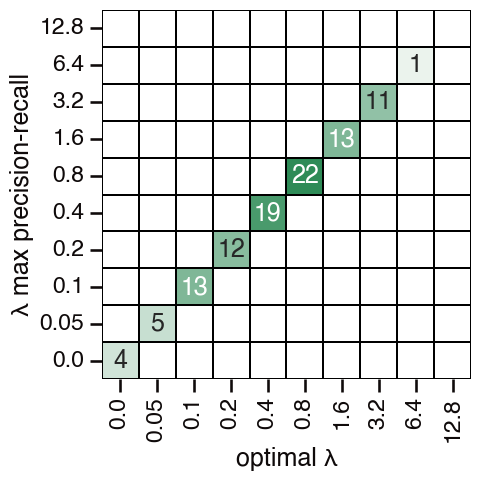

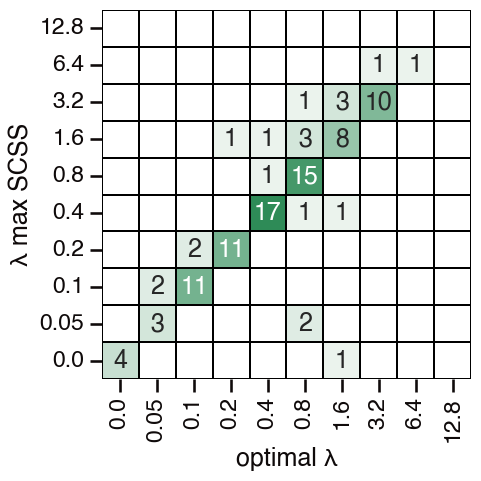

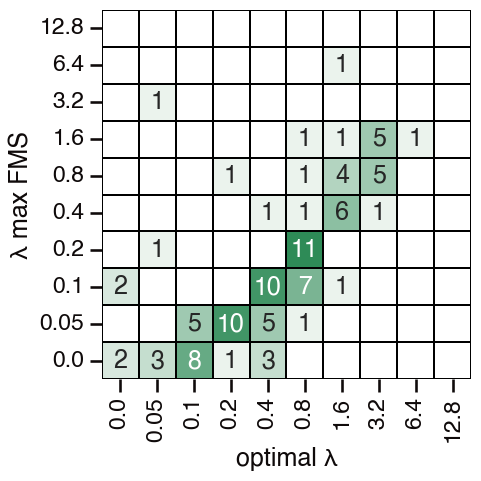

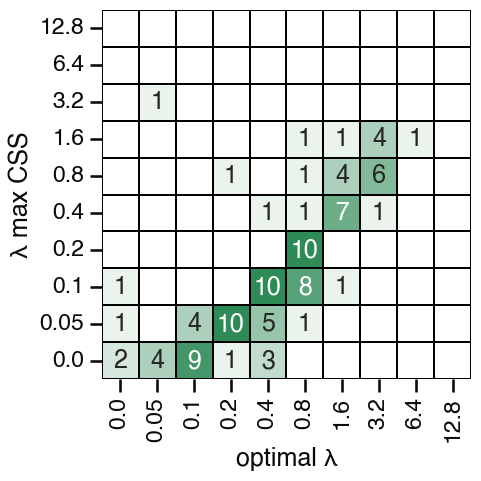

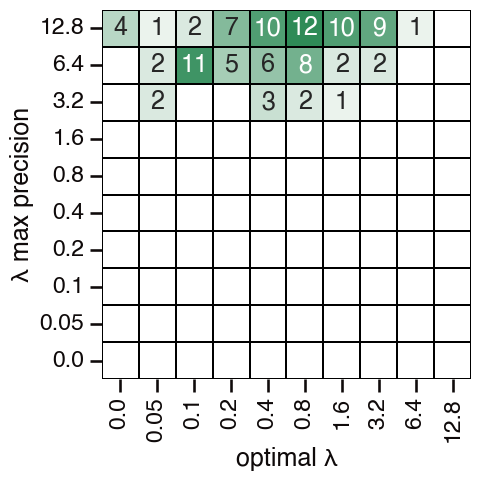

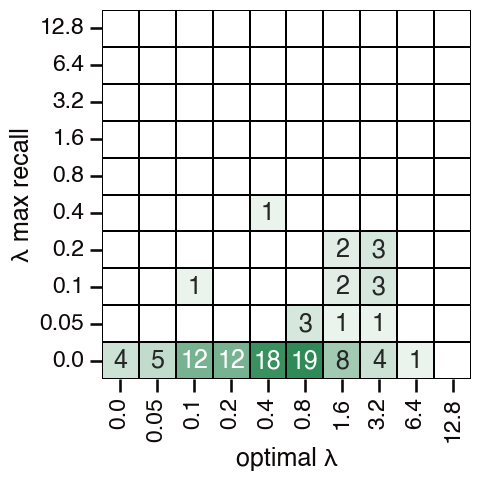

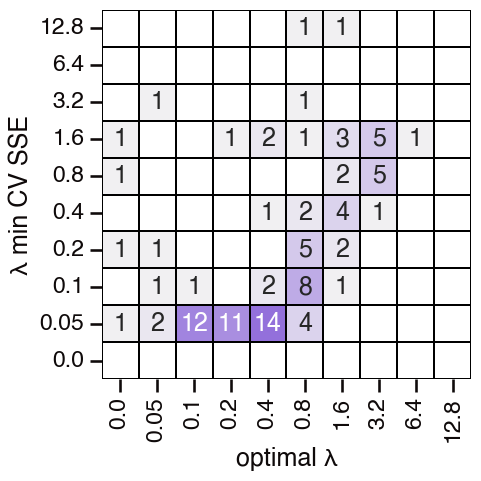

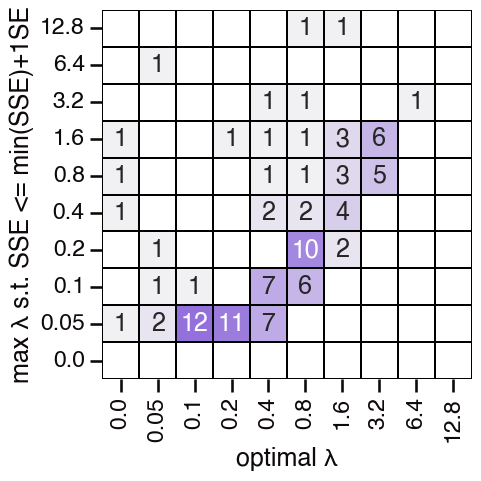

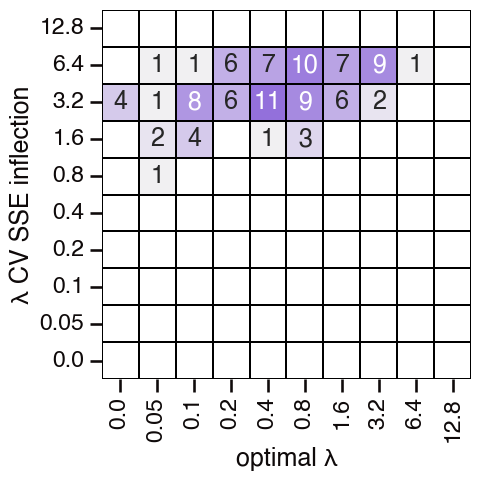

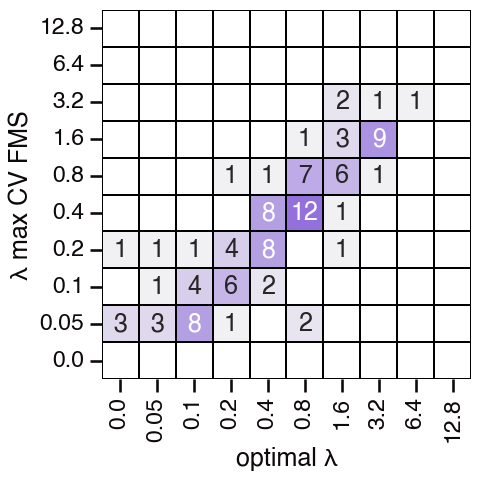

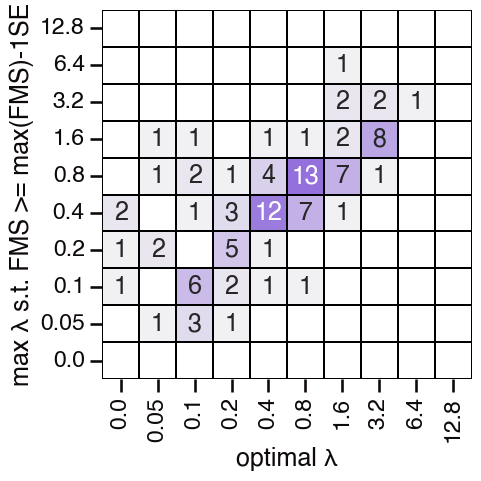

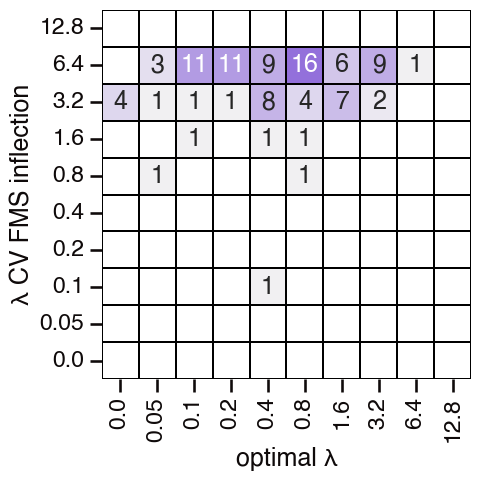

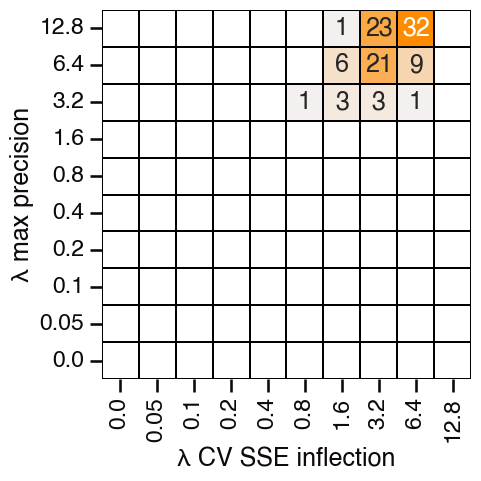

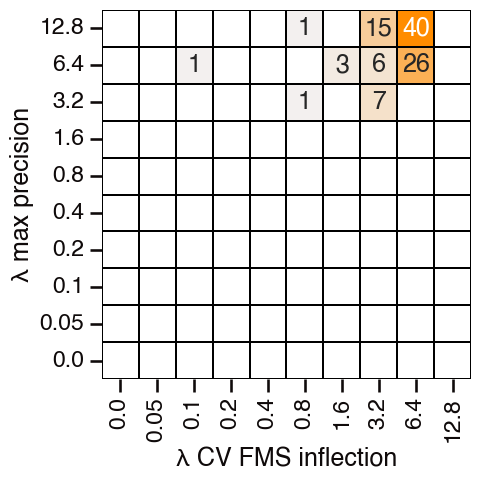

In [16]:
# make heatmap comparing optimal lambda values with methods of identification

# make template dataframe to house heatmap data
lambdas = results_df['lambda'].unique()
template_lambda_counts_df = pd.DataFrame(columns=lambdas, index=np.flip(lambdas)).fillna(0).astype(int)

# set up metrics to look at
comparison_values = [
    ('optimal_lambda', 'optimal λ', 'lambda_max_mprs', 'λ max precision-recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_scss_f0', 'λ max SCSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_fms', 'λ max FMS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_css_f0', 'λ max CSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_precision', 'λ max precision', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_recall', 'λ max recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse', 'λ min CV SSE', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse_1se', 'max λ s.t. SSE <= min(SSE)+1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_sse_inflection', 'λ CV SSE inflection', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms', 'λ max CV FMS', 'cv'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms_1se', 'max λ s.t. FMS >= max(FMS)-1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_fms_inflection', 'λ CV FMS inflection', 'cv'), 
    ('lambda_sse_inflection', 'λ CV SSE inflection', 'lambda_max_precision', 'λ max precision', 'other'), 
    ('lambda_fms_inflection', 'λ CV FMS inflection', 'lambda_max_precision', 'λ max precision', 'other')
]

# iterate through plots
for (col1, label1, col2, label2, dtype) in comparison_values:
    # arrange plot data
    plot_df = template_lambda_counts_df.copy()
    data_df = optimal_lambda_df[[col1, col2]].value_counts()
    for i, value in zip(data_df.index, data_df.values):
        plot_df.loc[i[1], i[0]] = value

    # set colormap based on datatype
    if dtype == 'gt':
        cmap = sns.color_palette('light:seagreen', as_cmap=True)
    elif dtype == 'cv':
        cmap = sns.color_palette('light:mediumpurple', as_cmap=True)
    else:
        cmap = sns.color_palette('light:darkorange', as_cmap=True)
        
    # make heatmap
    sns.heatmap(
        plot_df, 
        cmap=cmap, 
        annot=True, 
        linecolor='black', 
        linewidths=0.01, 
        cbar=False, 
        square=True, 
        mask=(plot_df == 0), 
    );
    plt.yticks(rotation=0)
    plt.xlabel(label1);
    plt.ylabel(label2);
#     plt.savefig('{}-v-{}.png'.format(col1, col2), bbox_inches='tight')
    plt.show()
    

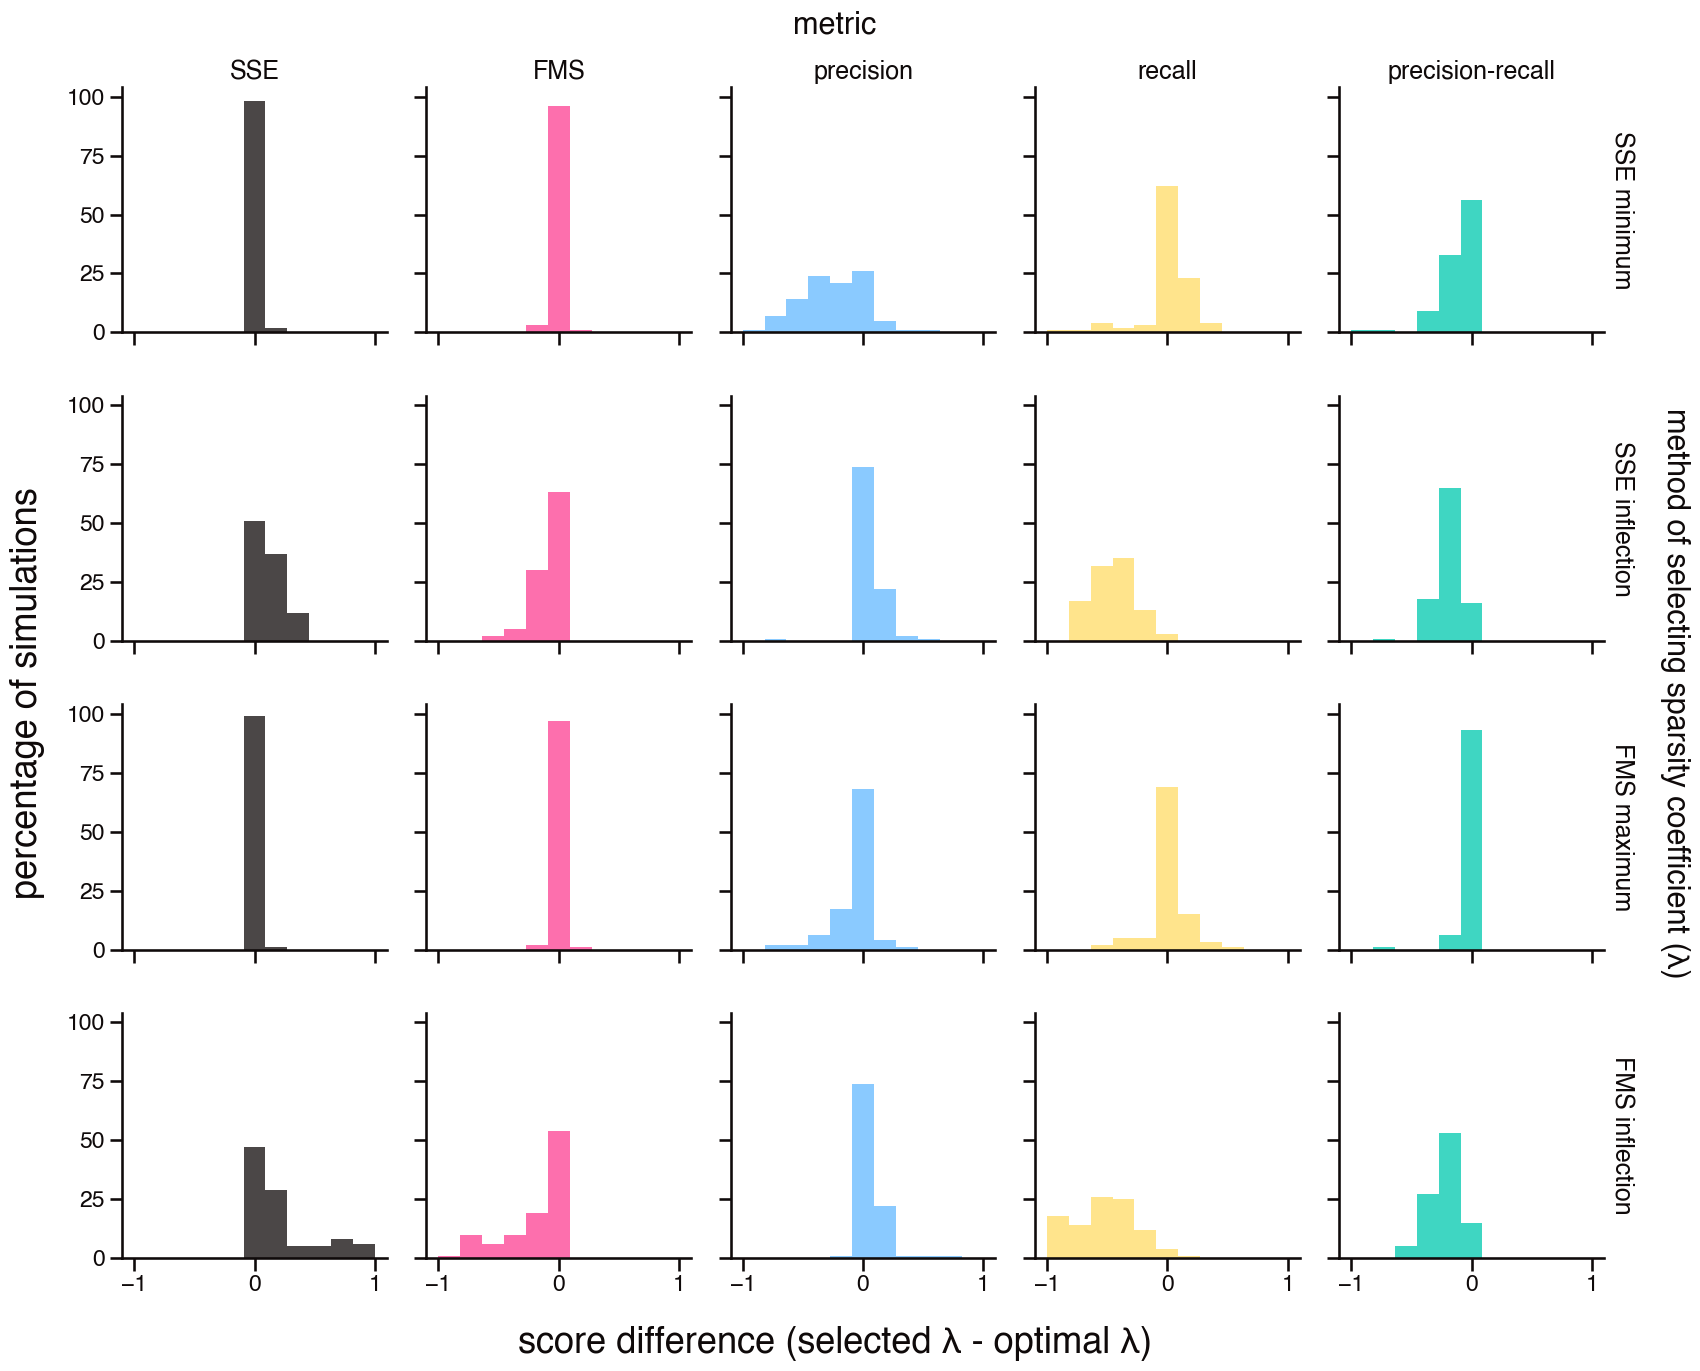

In [17]:
# look at difference between selected sparsity and optimal sparsity on a number of different metrics

# start with aggregated ground truth data
lambda_summary_df = gt_df_agg.copy()
# map back optimal rank and lambda, as well as noise
lambda_summary_df['optimal_rank'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_summary_df['optimal_lambda'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
lambda_summary_df['noise_level'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
# down-select to just optimal rank models
lambda_summary_df = lambda_summary_df[
    lambda_summary_df['rank'] == lambda_summary_df['optimal_rank']
].reset_index(drop=True)

# organize naming conventions for metrics
gt_metrics = ['gt_sse_mean', 'gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']
metrics = ['SSE', 'FMS', 'precision', 'recall', 'precision-recall']

# collect metrics 
gt_optimal_models_df = lambda_summary_df[
    lambda_summary_df['lambda'] == lambda_summary_df['optimal_lambda']
].reset_index(drop=True).rename(columns={
    k: f'{v}_optimal_lambda' for (k, v) in zip(gt_metrics, metrics)
}).drop(columns=['rank', 'lambda', 'optimal_rank', 'optimal_lambda', 'noise_level', 
                 'gt_recovery_mean', 'gt_relevance_mean', 'gt_recovery_relevance_mean'])

# add metrics for each method of selecting sparsity level
methods = [
#     'min_cv_sse', 
    'min_cv_sse_1se', 
    'sse_inflection', 
#     'max_cv_fms', 
    'max_cv_fms_1se', 
    'fms_inflection'
]

# compile methods comparison df
methods_comparison_df = pd.DataFrame()
for method in methods:
    working_df = lambda_summary_df.copy()
    # map method lambdas on working_df
    working_df['selected_lambda'] = working_df['simulation_id'].map(
        optimal_lambda_df.set_index('simulation_id')['lambda_{}'.format(method)]
    )
    # down-select to models with selected lambda
    working_df = working_df[working_df['lambda'] == working_df['selected_lambda']].rename(columns={
        k: f'{v}_selected_lambda' for (k, v) in zip(gt_metrics, metrics)
    })
    method_df = pd.merge(left=gt_optimal_models_df, right=working_df, on='simulation_id')
    # calculate differences
    for metric in metrics:
        method_df[metric] = method_df[f'{metric}_selected_lambda'] - method_df[f'{metric}_optimal_lambda']
    method_df['method'] = method
    if len(methods_comparison_df) == 0:
        methods_comparison_df = method_df
    else:
        methods_comparison_df = pd.concat([methods_comparison_df, method_df])

# melt methods comparison df for easy plotting
methods_comparison_df = methods_comparison_df.melt(
    id_vars=['simulation_id', 'method'], value_vars=metrics, var_name='metric'
)
# map method label for informative margin labels
methods_comparison_df['method'] = methods_comparison_df['method'].map({
    'min_cv_sse_1se': 'SSE minimum', 
    'sse_inflection': 'SSE inflection', 
    'max_cv_fms_1se': 'FMS maximum', 
    'fms_inflection': 'FMS inflection'
})
    
g = sns.FacetGrid(
    methods_comparison_df, 
    row='method', col='metric', hue='metric', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3, 7, 6, 2]]), 
    margin_titles=True,
    height=3.3
)
g.map(sns.histplot, 'value', bins=11, binrange=(-1, 1));
g.set_titles(row_template='{row_name}', col_template='{col_name}');
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='score difference (selected λ - optimal λ)', fontdict={'fontsize':26});
g.fig.text(0, .5, rotation=90, va='center', s='percentage of simulations', fontdict={'fontsize':26});
g.fig.text(.5, 1, ha='center', s='metric', fontdict={'fontsize':22});
g.fig.text(
    1, .5, rotation=270, va='center', s='method of selecting sparsity coefficient (λ)', fontdict={'fontsize':22}
);

g.savefig('sparsity-selection-method-comparison.png', bbox_inches='tight')
    

# Sparsity coefficient selection evaluation
- How close does FMS maximum get us to the optimal lambda?
- NOTE: 5 data points in which the optimal lambda was 0 were removed for ease of plotting.
    - 4/5 of these had a sparsity less than 0.08, and the fifth had a sparsity of 0.28 with a noise:signal ratio of 9.7


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


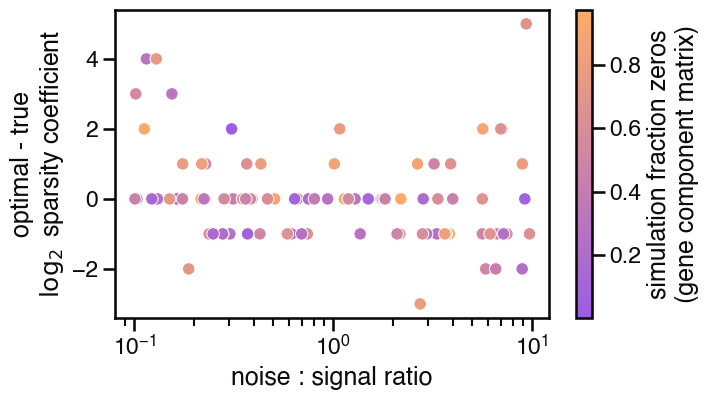

In [18]:
# plot true rank vs. optimal rank

# arrange data for plotting
lambda_plot_df = simulation_info_df.copy()
lambda_plot_df['lambda_max_cv_fms_1se'] = lambda_plot_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
lambda_plot_df['log_lambda_difference'] = np.log2(lambda_plot_df['lambda_max_cv_fms_1se']) - np.log2(lambda_plot_df['optimal_lambda'])
# lambda_plot_df = lambda_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
lambda_plot_df['true sparsity'] = 1 - lambda_plot_df['factor0_density']

# create plot
fig_b, ax_b = plt.subplots(figsize=[7, 4])
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
plt.xlabel('noise : signal ratio');
plt.ylabel('optimal - true\n$\log_2$ sparsity coefficient');
plt.xscale('log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true sparsity'].min(), lambda_plot_df['true sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, ax=ax_b, label='simulation fraction zeros\n(gene component matrix)');

# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


In [19]:
# look at simulations in which optimal lambda is zero

lambda_plot_df[lambda_plot_df['log_lambda_difference'] == np.inf]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,optimal_rank,optimal_lambda,lambda_max_cv_fms_1se,log_lambda_difference,true sparsity
57,57,8,"(156, 65, 69)",146.997880,7.315406,156,65,69,0.942294,0.289325,0.176497,6,0.0,0.4,inf,0.057706
77,77,5,"(465, 21, 39)",446.220759,4.965859,465,21,39,0.959615,0.492751,0.708791,5,0.0,0.2,inf,0.040385
87,87,6,"(466, 38, 33)",448.992994,2.048630,466,38,33,0.963504,0.698346,0.947308,6,0.0,0.4,inf,0.036496
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,9,0.0,0.1,inf,0.002172


# Lambda robustness to mis-specification
How off are different metrics when a sub-optimal lambda value is used?
    

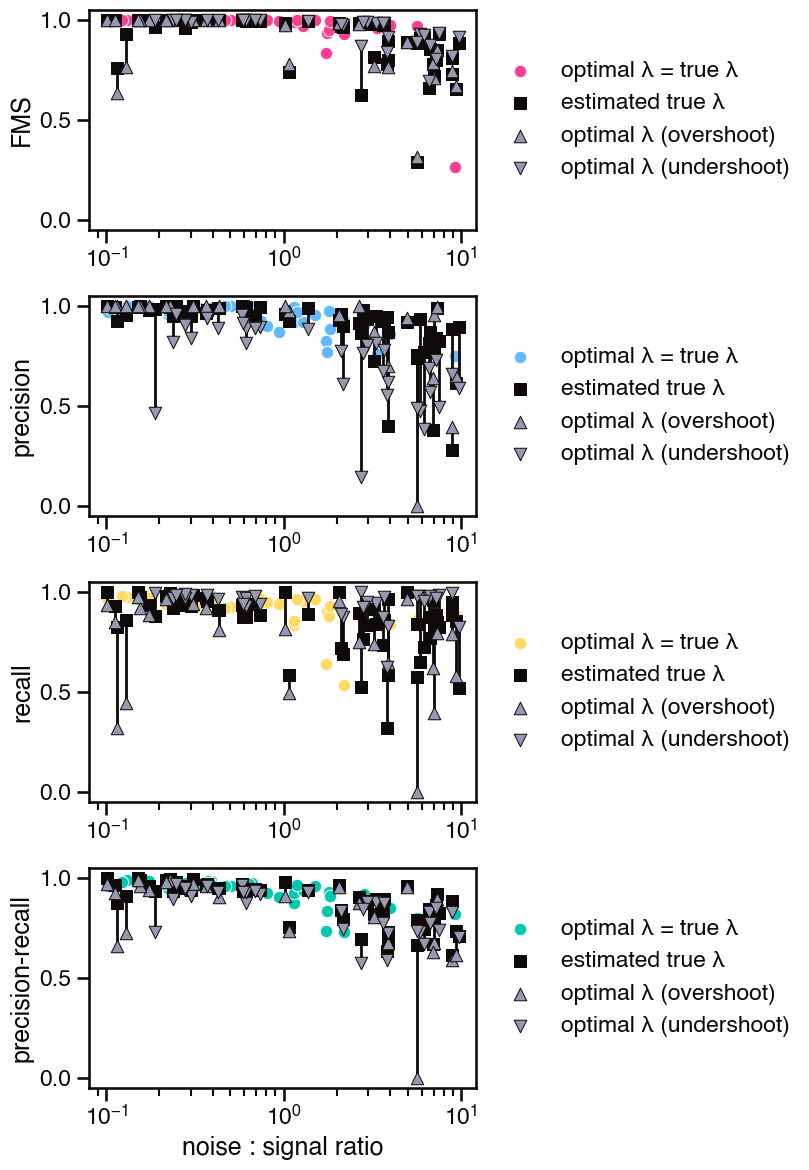

In [20]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_lambda_df = lambda_summary_df.copy()
robust_lambda_df['best_fit_lambda'] = robust_lambda_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
robust_lambda_df['comparison'] = 'match'
robust_lambda_df.loc[
    (robust_lambda_df['best_fit_lambda'] > robust_lambda_df['optimal_lambda']), 'comparison'] = 'overshoot'
robust_lambda_df.loc[
    (robust_lambda_df['best_fit_lambda'] < robust_lambda_df['optimal_lambda']), 'comparison'] = 'undershoot'

# set colors and labels
colors = {
    'gt_fms_mean': accent_colors[3], 
    'gt_precision_mean': accent_colors[7], 
    'gt_recall_mean': accent_colors[6], 
    'gt_precision_recall_mean': accent_colors[2], 
}
labels = {
    'gt_fms_mean': 'FMS', 
    'gt_precision_mean': 'precision', 
    'gt_recall_mean': 'recall', 
    'gt_precision_recall_mean': 'precision-recall', 
}

# plot each metric
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal λ = true λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['optimal_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['best_fit_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='estimated true λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal λ (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal λ (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Rank robustness to mis-specification

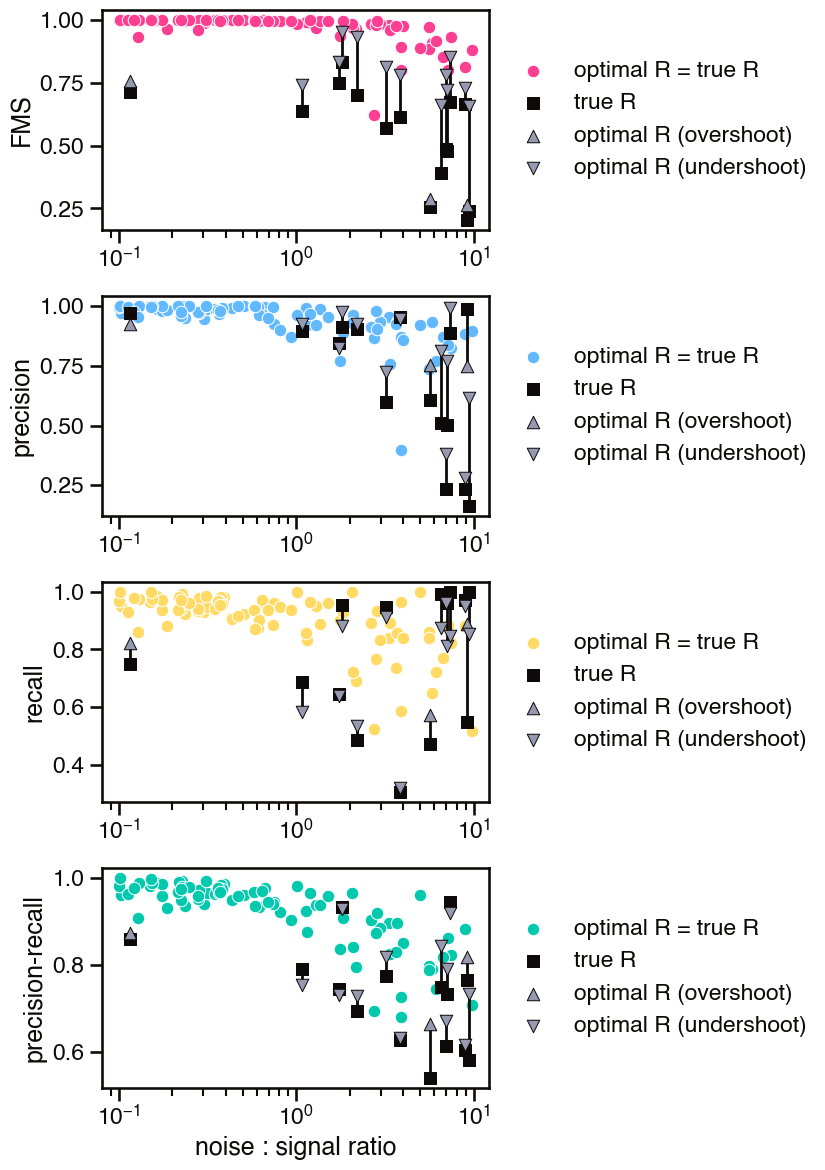

In [21]:
# compare scores of optimal and suboptimal rank values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_rank_df = gt_df_agg.copy()
robust_rank_df['true_rank'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['simulation_rank']
)
robust_rank_df['best_fit_rank'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
robust_rank_df['optimal_lambda'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
robust_rank_df['best_fit_lambda'] = robust_rank_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
robust_rank_df['noise_level'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
robust_rank_df['comparison'] = 'match'
robust_rank_df.loc[
    (robust_rank_df['best_fit_rank'] < robust_rank_df['true_rank']), 'comparison'] = 'undershoot'
robust_rank_df.loc[
    (robust_rank_df['best_fit_rank'] > robust_rank_df['true_rank']), 'comparison'] = 'overshoot'
robust_rank_df = robust_rank_df[robust_rank_df['lambda'] == robust_rank_df['optimal_lambda']]

# plot each metric
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal R = true R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['true_rank']][metric], 
        data_df[data_df['rank'] == data_df['best_fit_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='true R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal R (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal R (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log')
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log')
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


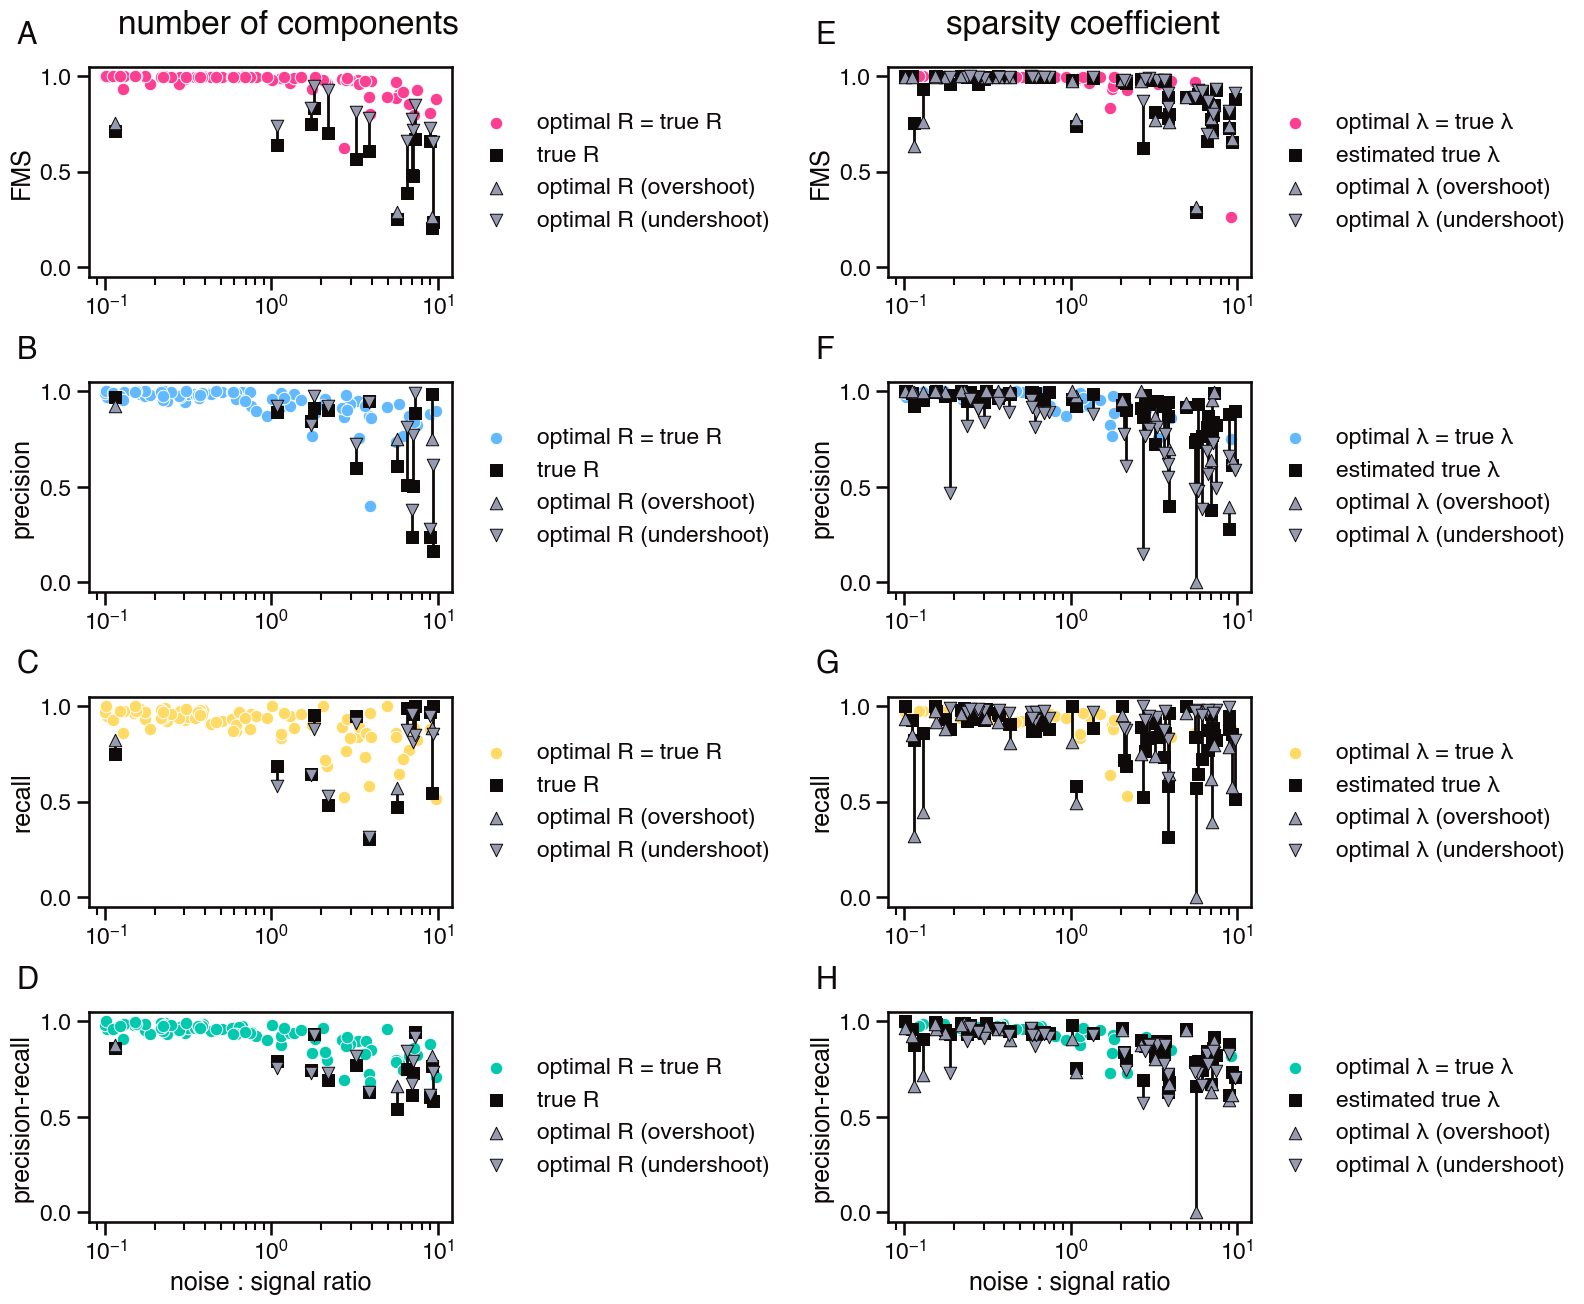

In [22]:
# panel figure: combine rank and lambda data

# make figure panel
fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(4, 2, figure=fig, hspace=.5, wspace=1.2)


# rank robustness to misspecification
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    axis.annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D'}[i], xy=(-0.2, 1.15), **annot_kwgs)
    if not i:
        axis.annotate('number of components', xy=(0.08, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal R = true R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['true_rank']][metric], 
        data_df[data_df['rank'] == data_df['best_fit_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='true R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal R (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal R (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# lambda robustness to misspecification
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 1])
    axis.annotate({0: 'E', 1: 'F', 2: 'G', 3: 'H'}[i], xy=(-0.2, 1.15), **annot_kwgs)
    if not i:
        axis.annotate('sparsity coefficient', xy=(0.16, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal λ = true λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['optimal_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['best_fit_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='estimated true λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal λ (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal λ (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
fig.savefig('robustness-to-misspecification.png', bbox_inches='tight')


# Hyperparameter tuning workflow validation figure

Main text figure to show the results of testing the hyperparameter gridsearch workflow using 100 simulated data tensors


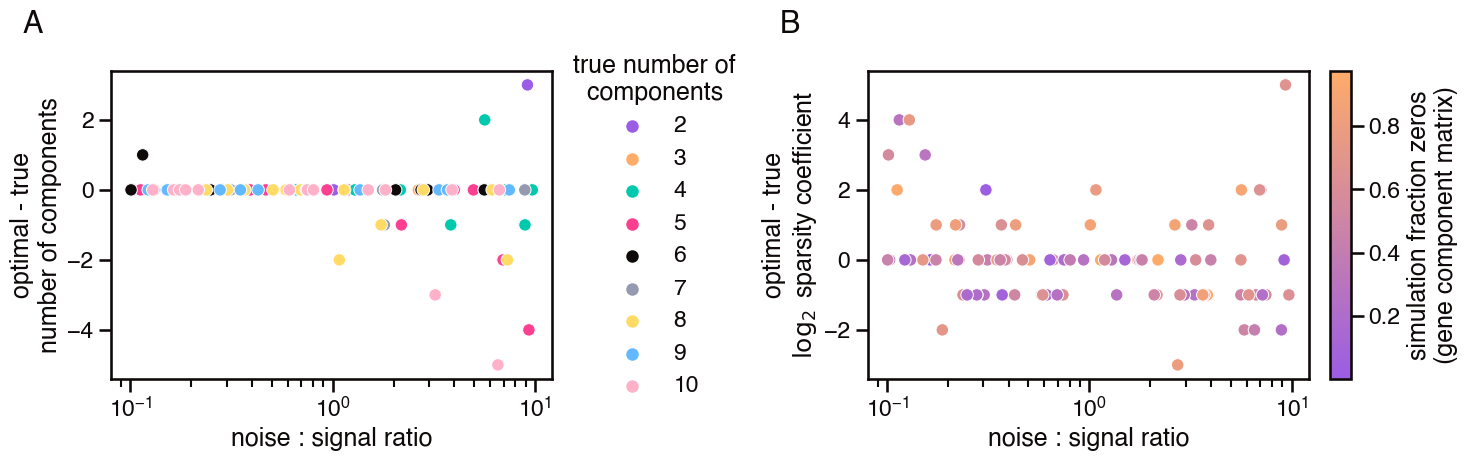

In [23]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(16, 4))
gs = plt.GridSpec(1, 30, wspace=1, figure=fig)

# plot true rank vs. optimal rank
ax_a = fig.add_subplot(gs[0, 0:11])
ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='best fit rank - true rank', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_a
)
ax_a.set(xlabel='noise : signal ratio', ylabel='optimal - true\nnumber of components', xscale='log')
ax_a.legend(title='true number of\n  components', loc='center left', bbox_to_anchor=[1, .5]);


# plot lambda validation
ax_b = fig.add_subplot(gs[0, 18:29])
ax_b.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
ax_b.set(xlabel='noise : signal ratio', ylabel='optimal - true\n$\log_2$ sparsity coefficient', xscale='log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true sparsity'].min(), lambda_plot_df['true sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, cax=fig.add_subplot(gs[0, 29]), 
                     label='simulation fraction zeros\n(gene component matrix)', aspect=20);

plt.savefig('cv-parameterization-validation.png', bbox_inches='tight')
